In [2]:
%matplotlib inline


from __future__ import division

import numpy as np
import scipy.optimize as op
import time
import copy as cp

import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
seaborn.set(font_scale=2)
seaborn.set_style("white")



# Define Hyperparameter Functions

In [3]:
def kernel(t,t2,tav,k,sigma_s,clean=False):
    a0 =np.meshgrid(t,t2)
    dst = a0[0] - a0[1]
    K = k*np.exp(-.5*tav*dst**2)
    
    if clean:
        return K,dst
    else:
        K += np.eye(len(t))*sigma_s
        return K,dst

In [4]:
def logP(params,t,t2,y):
    
    tav = params[0]; k = params[1]; eps = params[2]
    tav = np.exp(tav); k = np.exp(k); eps = np.exp(eps)
    K, _ = kernel(t,t2,tav,k=k,sigma_s = eps)
    K_inv = np.linalg.inv(K)
    a,b = np.linalg.slogdet(K)
    t1 = -.5*np.dot(np.dot(y,K_inv),y) - .5*(a*b) - len(t)*np.log(1*np.pi)/2
    return -t1

In [5]:
def logP_grad_Y(params,t,t2,y):
    
    #this one seems to work
    tav = params[0]; k = params[1]; eps = params[2]
    tav = np.exp(tav); k = np.exp(k); eps = np.exp(eps)
    K, dst = kernel(t,t2,tav,k=k,sigma_s=eps)
    sqDst = .5*tav*dst**2
    K_inv = np.linalg.inv(K)
    
    a0 = np.dot(K_inv,y)
    alpha = np.array([a0])
    
    t1 = alpha.T.dot(alpha) - K_inv
    dKdt = sqDst*K
    dKdk = -(K-np.eye(len(t))*eps)
    dKdS = -eps*np.eye(len(t))
    
    g0 = .5*np.trace(t1.dot(dKdt))
    g1 = .5*np.trace(t1.dot(dKdk))
    g2 = .5*np.trace(t1.dot(dKdS))
    return np.array([g0,g1,g2])

## Generate Some Fake Data

In [6]:
n_timePoints = 200

t = np.arange(n_timePoints)

k = 1; sigmaS = .2; tav = .02
true_params = {'tav':tav,
               'k': k,
               'sigmaS': sigmaS}
K,_ = kernel(t,t,tav,k,sigmaS)

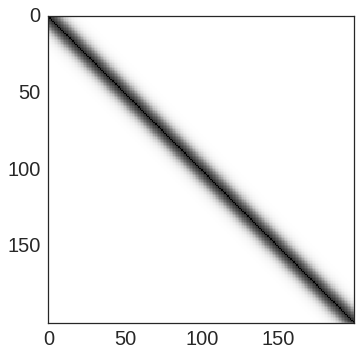

In [7]:
plt.imshow(K,interpolation='None')

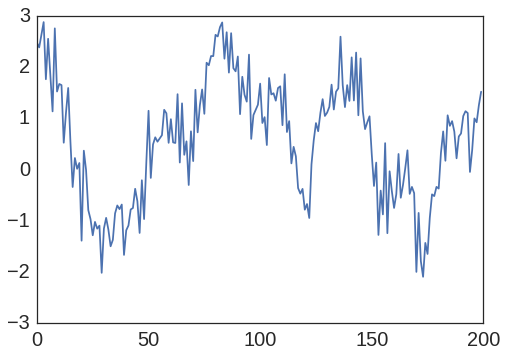

In [8]:
samp = np.random.multivariate_normal(np.zeros(n_timePoints),K)
plt.plot(samp)

In [31]:
#samp = np.concatenate([[.1,.4,1.,1.5,2.2,4],np.linspace(4,0,num=20)])
import pickle
samp = pickle.load(open('/home/yves/Desktop/testD.p'))
t = np.arange(len(samp))

In [33]:
#ans2 = op.approx_fprime([2,1,.1],
#                logP,
#                1e-7,
#                t,t,samp)#
#
#print ans2

In [34]:
#logP_grad_Y([2,1,.1],t,t,samp)

In [35]:
res = op.fmin_tnc(func=logP,
                  x0=np.array([0,.1,1]),
                  fprime=logP_grad_Y,
                  args=(t,t,samp),
                  maxfun=1000)

In [36]:
np.exp(res[0])

array([ 0.03102349,  0.57649604,  0.10467191])

In [37]:
print true_params

{'tav': 0.02, 'k': 1, 'sigmaS': 0.2}


In [38]:
st = time.time()
res = op.minimize(fun=logP,
            x0=np.array([0,0,0]),
            jac=logP_grad_Y,
            args=(t,t,samp),
            method='TNC',
            options = {'disp': 1,'gtol':1e-16,'xtol':1e-16,'ftol':1e-16,'maxiter':200})
print time.time() - st
print res

0.0764241218567
     fun: 8.9256111992863296
     jac: array([  2.05494552e-08,  -3.22124114e-08,  -1.67323670e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 53
     nit: 19
  status: 1
 success: True
       x: array([-3.47300955, -0.55078663, -2.25692443])


In [39]:
print np.exp(res.x)

[ 0.03102352  0.57649614  0.10467192]


In [40]:
print [i for i in np.exp(res.x)]

[0.031023523193531147, 0.57649614234828428, 0.10467191599092988]


In [41]:
print true_params

{'tav': 0.02, 'k': 1, 'sigmaS': 0.2}


$$ 

In [59]:
def fit(y,t,t2,params):
    
    tav = params[0]
    sigmaS = params[2]
    k = params[1]
    
    
    if np.array_equal(t,t2):
        print 'smoothing'
        K,_ = kernel(t,t2,tav,k,sigmaS,clean=True)
        new_mu = K.dot(np.linalg.inv(K+np.eye(len(y))*sigmaS)).dot(y)
        new_cov = K - K.dot(np.linalg.inv(K+np.eye(len(y))*sigmaS)).dot(K)
    else:
        print 'inference'
        K,_ = kernel(t,t,tav,k,sigmaS,clean=True)
        Kst,_ = kernel(t,t2,tav,k,sigmaS,clean=True)
        Kstst, _ = kernel(t2,t2,tav,k,sigmaS,clean=True)
        temp1 = Kst.dot( np.linalg.inv(K + np.eye(len(t))*sigmaS))
        new_mu = np.dot(temp1,y)
        new_cov = Kstst - np.dot(temp1,Kst.T)
    return new_mu, new_cov
    
def predict(x,y,y_pred):
    return None

In [56]:
params = np.exp(res.x)

In [57]:
ssst = samp[20]

inf


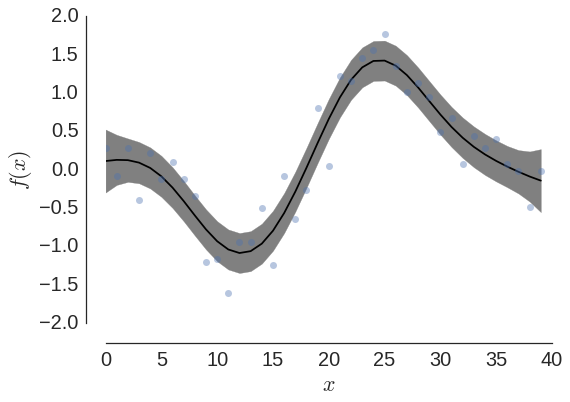

In [58]:
sti = 45;ndi = 55
t = np.arange(len(samp))
#t1 = np.concatenate([t[:sti],t[ndi:]])
#t2 = t[sti:ndi]
#samp[20] = ssst
#y = np.concatenate([samp[:sti],samp[ndi:]])
mu,c = fit(samp,t,t,params)
varnc = 2*np.sqrt(np.diag(c))

plt.plot(mu,color='k')
plt.plot(t1,y,'o',alpha=.4)
plt.plot(t2,samp[sti:ndi],'o',alpha=.4)
plt.fill_between(t,mu+varnc,mu-varnc,color=[.5]*3)
seaborn.despine(trim=0,offset=20)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

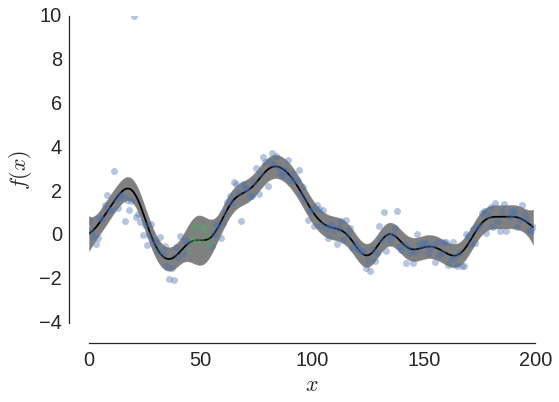

In [1015]:
sti = 45;ndi = 55
t = np.arange(len(samp))
t1 = np.concatenate([t[:sti],t[ndi:]])
t2 = t[sti:ndi]
samp[20] = 10
y = np.concatenate([samp[:sti],samp[ndi:]])
mu,c = fit(y,t1,t,params)
varnc = 2*np.sqrt(np.diag(c))

plt.plot(mu,color='k')
plt.plot(t1,y,'o',alpha=.4)
plt.plot(t2,samp[sti:ndi],'o',alpha=.4)
plt.fill_between(t,mu+varnc,mu-varnc,color=[.5]*3)
seaborn.despine(trim=0,offset=20)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

(100, 100)